# HIPPO for 2A Protease (6/?)

## Imports

In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
%autoreload 2
from pathlib import Path
import molparse as mp
import hippo2 as hippo
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from pprint import pprint
import json
import mout
import pickle
from rdkit.Chem import PandasTools

## Load the project

In [20]:
# animal = hippo.HIPPO.from_pickle('pickles/2A_hippo_fingerprinted_trim.pickle')
animal = hippo.HIPPO.from_pickle('pickles/2A_hippo_allfragnet_random_latest.pickle')

path = pickles/2A_hippo_allfragnet_random_latest.pickle 


In [21]:
animal.bases

CompoundSet("bases", #compounds=25, #poses=1)

## Load the BBSs

In [22]:
bbs_dir = Path('bbs_allfragnet_3k')

In [23]:
catalytic_poses = animal.get_poses('Catalytic', search=True, all_poses=animal.hits.poses)
print(catalytic_poses)
CATALYTIC_FEATURES = catalytic_poses.get_present_features()
N_CATALYTIC_FEATURES = len(CATALYTIC_FEATURES)

PoseSet(#poses=8, [0A, 0A, 0A, 0A, 0A, 0A, 0A, 0A])


In [24]:
def catalytic_features(bbs):
    features = bbs.products.get_present_features()
    return len([f for f in CATALYTIC_FEATURES if f in features])

def num_features(bbs):
    features = bbs.products.get_present_features()
    return len(features)

In [25]:
def num_bases(bbs):
    # print(bbs.products)
    return len(set([p.base.name for p in bbs.products if p.base is not None]))

def num_products(bbs):
    return len(bbs.products)

from collections import Counter
import numpy as np

def base_balance(bbs):
    bases = [p.base.name for p in bbs.products if p.base is not None]
    counter = Counter(bases)
    # for base in set(bases):
        # print(base, counter[base])
    return np.std([counter[base] for base in set(bases)])

In [26]:
base_balance(p)

1.9595917942265426

In [27]:
pickles = bbs_dir.glob('BBS_???.pickle')
bb_sets = []
n=2000
for i,p in enumerate(pickles):
    # if i > 500:
        # break
    # if i%10 == 0:
        # mout.out(f'{i=}')
    mout.progress(i,n,append=f'{i=} {p.name}')
    p = pickle.load(open(p, 'rb'))

    d = dict(
        name=p.name,
        catalytic_features=catalytic_features(p),
        num_features=num_features(p),
        num_bases=num_bases(p),
        num_products=num_products(p),
        base_balance=base_balance(p),
    )
    
    bb_sets.append(d)

[########################## ]  99.95% i=1999 BBS_CYX.pickle

In [28]:
mout.interrupt()

[############## ]  99.95% i=1999 BBS_CYX.pickle INTERRUPTED


## Define the scorer

In [35]:
print('start')
scorer = hippo.scoring.Scorer(
    animal, 
    bb_sets, 
    ['num_products',
     'num_bases',
     'catalytic_features',
     'num_features',
     'base_balance',
    ])
    # ['num_products'])

# print('num_products')
# scorer.add_attribute(hippo.scoring.CustomAttribute('num_products', bb_sets, num_products))
# print('num_bases')
# scorer.add_attribute(hippo.scoring.CustomAttribute('num_bases', bb_sets, num_bases))
# print('catalytic_features')
# scorer.add_attribute(hippo.scoring.CustomAttribute('catalytic_features', bb_sets, catalytic_features))
# print('num_features')
# scorer.add_attribute(hippo.scoring.CustomAttribute('num_features', bb_sets, num_features))

scorer.weights = [1.0, 0.5, 1.0, 0.25, -0.25]

start
>>> Scorer(HIPPO(hippo2_test))         
>>> Getting values for Attribute(num_products)...
>>> Getting values for Attribute(num_bases)...
>>> Getting values for Attribute(catalytic_features)...
>>> Getting values for Attribute(num_features)...
>>> Getting values for Attribute(base_balance)...


In [36]:
top = scorer.top(5)

>>> sorting 2000 BB sets...            


In [37]:
for bbs in top:
    mout.header(bbs['name'])
    scorer.score(bbs, verbosity=1)

BBS_CPN                                         
                  key    weight       value          unweighted  weighted
0        num_products  0.333333   40.000000  0.9973529411764702  0.332451
1           num_bases  0.166667    9.000000  0.9719444444444446  0.161991
2  catalytic_features  0.333333   50.000000  0.9959615384615381  0.331987
3        num_features  0.083333  136.000000  0.9974024390243895  0.083117
4        base_balance  0.083333    2.712568              0.3292  0.027433
score = 0.93697911                
BBS_AVS                                         
                  key    weight       value          unweighted  weighted
0        num_products  0.333333   35.000000  0.9883529411764704  0.329451
1           num_bases  0.166667    9.000000  0.9719444444444446  0.161991
2  catalytic_features  0.333333   48.000000  0.9882692307692308  0.329423
3        num_features  0.083333  138.000000  0.9981707317073163  0.083181
4        base_balance  0.083333    3.735053          

## Plotting

In [38]:
label=[bbs['name'] for bbs in top]

plot_data = []
for bbs in bb_sets:
    d = dict(
        name=bbs['name'],
        score=scorer(bbs),
        label = bbs['name'] if bbs['name'] in label else '',
    )

    for attribute in scorer.attributes:
        d[attribute.key] = attribute.get_value(bbs)

    plot_data.append(d)

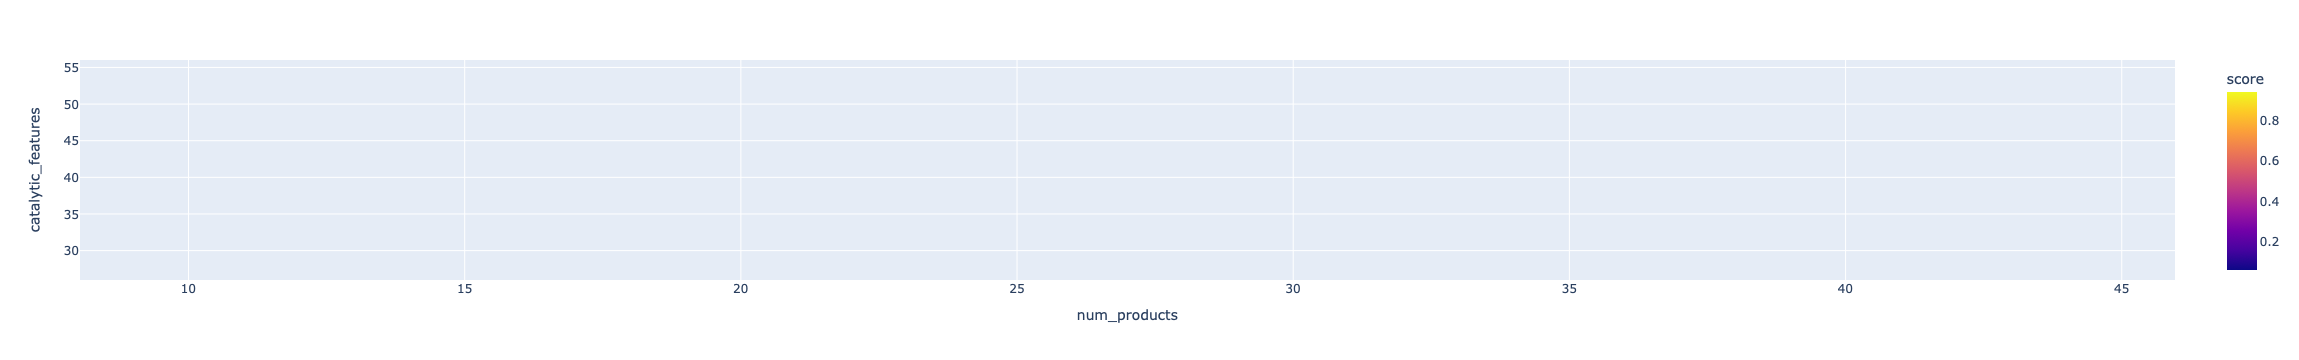

In [41]:
px.scatter(plot_data, x='num_products', y='catalytic_features', color='score', hover_data=plot_data[0].keys(), text='label')

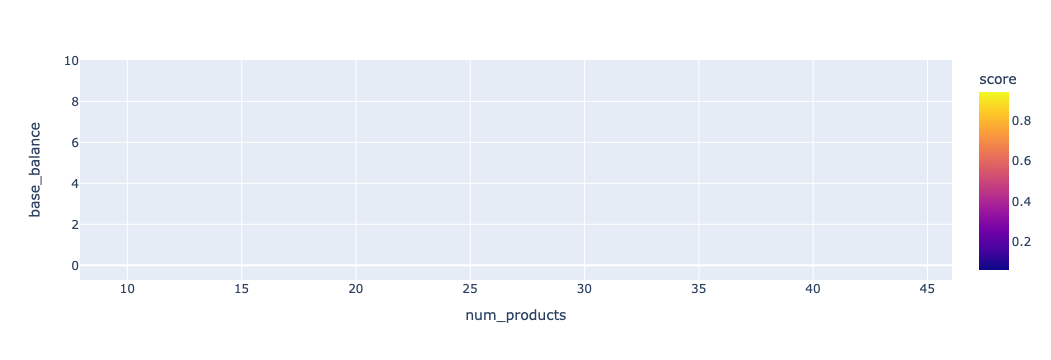

In [40]:
px.scatter(plot_data, x='num_products', y='base_balance', color='score', hover_data=plot_data[0].keys(), text='label')

## Write CSV

In [42]:
chosen = top[0]
chosen = pickle.load(open(bbs_dir/f'{chosen["name"]}.pickle', 'rb'))

In [36]:
chosen = pickle.load(open(bbs_dir/f'BBS_AIN.pickle', 'rb'))

In [43]:
chosen.name

'BBS_CPN'

In [44]:
for bb in chosen:
    bb.__num_reactions = 0
    
for comp in chosen.products:
    # print(comp.reaction)
    for bb in comp.reaction.reactants:
        chosen[bb.name].__num_reactions += 1
        # print(chosen[bb.name])

In [45]:
df_data = []
for bb in chosen:
    # print(bb)

    pack = bb.price_picker.get_pack(bb.amount)

    # reactions = animal.building_blocks[bb.name].amount

    d = dict(
        name=bb.name,
        smiles=bb.smiles,
        required_amount=bb.amount,
        quoted_amount=pack['amount'],
        price=pack['price'],
        lead_time=bb.lead_time,
        num_reactions=bb.__num_reactions,
    )
    
    df_data.append(d)

In [46]:
df = pd.DataFrame(df_data)

In [47]:
df

,name,smiles,required_amount,quoted_amount,price,lead_time,num_reactions
0,EN300-37373250,O=C(O)C(CBr)C(F)(F)F,20,50.0,202.0,5,1
1,EN300-27260,CC(C)(C)c1cc(N)n(CCO)n1,24,50.0,82.0,5,5
2,EN300-393586,O=C(O)C(CO)C(F)(F)F,23,50.0,64.0,5,4
3,EN300-27636,Cc1cc2n(n1)C(C(F)(F)F)CCN2,20,50.0,24.0,5,1
4,EN300-72730,CC(C#N)C(=O)O,27,50.0,51.0,5,8
5,Z1262044157,CC(C)(C)Cc1cc(NC(=O)Cn2cnnn2)[nH]n1,20,20.0,122.7,5,1
6,EN300-115408,CCC/C=C(/C#N)C(=O)O,23,50.0,179.0,5,4
7,EN300-12177685,CC(N)C(=O)Nc1cc(C(F)(F)F)[nH]n1,29,50.0,216.0,5,10
8,EN300-180188,O=C(O)C(F)C(F)(F)F,23,50.0,19.0,5,4
9,EN300-345176,CCc1nn(C)c(NC)c1N,23,50.0,174.0,5,4


In [48]:
df.to_csv(f'picks/{chosen.name}.csv')

In [49]:
df['required_amount'].sum()

536

In [52]:
df['price'].mean()

124.89583333333333

In [50]:
df['quoted_amount'].sum()

1141.0

# Write SDF

In [56]:
chosen.products.df

,_Name,ROMol,name,smiles,orig_smiles,crystal_name,num_poses,num_reactions,reactions,base,inspirations
0,steph-fragnetv2-Z3608273487-1-of-1-step-00015,<rdkit.Chem.rdchem.Mol object at 0x2adaee854cc0>,steph-fragnetv2-Z3608273487-1-of-1-step-00015,CC(C)(C)c1cc(NC(=O)C(CBr)C(F)(F)F)n(CCO)n1,CC(C)(C)c1cc(NC(=O)[C@H](CBr)C(F)(F)F)n(CCO)n1,None,2,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z3608273487-1-of-1-s...,"[x0556_0A, x0310_0A]"
1,steph-fragnetv2-Z393051624-1-of-1-step-03740,<rdkit.Chem.rdchem.Mol object at 0x2adae7aaebb0>,steph-fragnetv2-Z393051624-1-of-1-step-03740,Cc1cc2n(n1)C(C(F)(F)F)CCN2C(=O)C(CO)C(F)(F)F,Cc1cc2n(n1)[C@@H](C(F)(F)F)CCN2C(=O)[C@@H](CO)...,None,2,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z393051624-1-of-1-st...,"[x0556_0A, x0310_0A]"
2,steph-fragnetv2-Z1726449759-1-of-1-step-00924,<rdkit.Chem.rdchem.Mol object at 0x2adae7aaf560>,steph-fragnetv2-Z1726449759-1-of-1-step-00924,CC(C#N)C(=O)n1nc(CC(C)(C)C)cc1NC(=O)Cn1cnnn1,C[C@H](C#N)C(=O)n1nc(CC(C)(C)C)cc1NC(=O)Cn1cnnn1,None,2,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z1726449759-1-of-1-s...,"[x0556_0A, x0310_0A]"
3,steph-fragnetv2-Z2957505129-1-of-1-step-02277,<rdkit.Chem.rdchem.Mol object at 0x2adae7aac450>,steph-fragnetv2-Z2957505129-1-of-1-step-02277,CCC/C=C(\C#N)C(=O)NC(C)C(=O)Nc1cc(C(F)(F)F)[nH]n1,CCC/C=C(\C#N)C(=O)N[C@@H](C)C(=O)Nc1cc(C(F)(F)...,None,1,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z2957505129-1-of-1-s...,"[x0556_0A, x0310_0A]"
4,steph-fragnetv2-Z1217419270-1-of-1-step-02542,<rdkit.Chem.rdchem.Mol object at 0x2adae7aae390>,steph-fragnetv2-Z1217419270-1-of-1-step-02542,CCc1nn(C)c(NC)c1NC(=O)C(F)C(F)(F)F,CCc1nn(C)c(NC)c1NC(=O)[C@H](F)C(F)(F)F,None,2,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z1217419270-1-of-1-s...,"[x0556_0A, x0310_0A]"
5,steph-fragnetv2-Z393051624-1-of-1-step-05972,<rdkit.Chem.rdchem.Mol object at 0x2adae7aada80>,steph-fragnetv2-Z393051624-1-of-1-step-05972,CCOC(=O)Cn1nc(C)cc1NC(=O)C(N)(CCCOC)C(F)(F)F,CCOC(=O)Cn1nc(C)cc1NC(=O)[C@](N)(CCCOC)C(F)(F)F,None,2,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z393051624-1-of-1-st...,"[x0556_0A, x0310_0A]"
6,steph-fragnetv2-113738-B1X-1-of-1-step-00337,<rdkit.Chem.rdchem.Mol object at 0x2adae6d42570>,steph-fragnetv2-113738-B1X-1-of-1-step-00337,Nc1ccncc1CNC(=O)C1CC(Cl)C1,Nc1ccncc1CNC(=O)[C@H]1C[C@H](Cl)C1,None,1,1,"[{'type': 'Amide_Schotten-Baumann_with_amine',...",{'name': 'steph-fragnetv2-113738-B1X-1-of-1-st...,"[x0416_0A, x0310_0A]"
7,steph-fragnetv2-113738-B1X-1-of-1-step-01477,<rdkit.Chem.rdchem.Mol object at 0x2adae7a144a0>,steph-fragnetv2-113738-B1X-1-of-1-step-01477,Nc1cc(NC(=O)C2CC(Cl)C2)c(C(=O)O)cn1,Nc1cc(NC(=O)[C@H]2C[C@@H](Cl)C2)c(C(=O)O)cn1,None,1,1,"[{'type': 'Amide_Schotten-Baumann_with_amine',...",{'name': 'steph-fragnetv2-113738-B1X-1-of-1-st...,"[x0416_0A, x0310_0A]"
8,steph-fragnetv2-Z1726449759-1-of-1-step-01455,<rdkit.Chem.rdchem.Mol object at 0x2adae7a146d0>,steph-fragnetv2-Z1726449759-1-of-1-step-01455,CC(C)(C)Cc1cc(NC(=O)c2cn(C(=O)/C(C#N)=N/O)nn2)...,CC(C)(C)Cc1cc(NC(=O)c2cn(C(=O)/C(C#N)=N/O)nn2)...,None,2,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z1726449759-1-of-1-s...,"[x0556_0A, x0310_0A]"
9,steph-fragnetv2-Z3207230890-1-of-1-step-00004,<rdkit.Chem.rdchem.Mol object at 0x2adae7a14c70>,steph-fragnetv2-Z3207230890-1-of-1-step-00004,CC(C#N)C(=O)n1nc(C2(C)CC2)cc1N,C[C@@H](C#N)C(=O)n1nc(C2(C)CC2)cc1N,None,4,1,"[{'type': 'Amidation', 'product_name': 'steph-...",{'name': 'steph-fragnetv2-Z3207230890-1-of-1-s...,"[x0556_0A, x0310_0A]"


In [69]:
df = chosen.products.poses.df
df

,_Name,ROMol,compound,name,longname,site_index,chain,pdb_path
0,steph-fragnetv2-Z3608273487-1-of-1-step-00015_A,<rdkit.Chem.rdchem.Mol object at 0x2adae7ae9030>,{'name': 'steph-fragnetv2-Z3608273487-1-of-1-s...,A,steph-fragnetv2-Z3608273487-1-of-1-step-00015_A,0,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
1,steph-fragnetv2-Z3608273487-1-of-1-step-00015_B,<rdkit.Chem.rdchem.Mol object at 0x2adae7aea6b0>,{'name': 'steph-fragnetv2-Z3608273487-1-of-1-s...,B,steph-fragnetv2-Z3608273487-1-of-1-step-00015_B,1,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
2,steph-fragnetv2-Z393051624-1-of-1-step-03740_A,<rdkit.Chem.rdchem.Mol object at 0x2adae7aaec00>,{'name': 'steph-fragnetv2-Z393051624-1-of-1-st...,A,steph-fragnetv2-Z393051624-1-of-1-step-03740_A,0,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
3,steph-fragnetv2-Z393051624-1-of-1-step-03740_B,<rdkit.Chem.rdchem.Mol object at 0x2adae7aaede0>,{'name': 'steph-fragnetv2-Z393051624-1-of-1-st...,B,steph-fragnetv2-Z393051624-1-of-1-step-03740_B,1,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
4,steph-fragnetv2-Z1726449759-1-of-1-step-00924_A,<rdkit.Chem.rdchem.Mol object at 0x2adae7aaf6a0>,{'name': 'steph-fragnetv2-Z1726449759-1-of-1-s...,A,steph-fragnetv2-Z1726449759-1-of-1-step-00924_A,0,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
...,...,...,...,...,...,...,...,...
69,steph-fragnetv2-Z1217419270-1-of-1-step-03601_B,<rdkit.Chem.rdchem.Mol object at 0x2adae7a14ea0>,{'name': 'steph-fragnetv2-Z1217419270-1-of-1-s...,B,steph-fragnetv2-Z1217419270-1-of-1-step-03601_B,1,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
70,steph-fragnetv2-Z2957505129-1-of-1-step-00258_A,<rdkit.Chem.rdchem.Mol object at 0x2adae7c45080>,{'name': 'steph-fragnetv2-Z2957505129-1-of-1-s...,A,steph-fragnetv2-Z2957505129-1-of-1-step-00258_A,0,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
71,steph-fragnetv2-Z2957505129-1-of-1-step-00258_B,<rdkit.Chem.rdchem.Mol object at 0x2adae7c45120>,{'name': 'steph-fragnetv2-Z2957505129-1-of-1-s...,B,steph-fragnetv2-Z2957505129-1-of-1-step-00258_B,1,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...
72,steph-fragnetv2-Z2957505129-1-of-1-step-00923_A,<rdkit.Chem.rdchem.Mol object at 0x2adae7a152b0>,{'name': 'steph-fragnetv2-Z2957505129-1-of-1-s...,A,steph-fragnetv2-Z2957505129-1-of-1-step-00923_A,0,None,../aligned/A71EV2A-x0310_0A/A71EV2A-x0310_0A_b...


In [70]:
PandasTools.WriteSDF(df,'picks/BBS_CPN_product_poses.sdf')